In [2]:
import sqlite3
import pathlib
from typing import List, Optional, Union
import pandas as pd

def pandas_load_sqlite(sqlite_path: Union[str, pathlib.Path], table: str, columns: Optional[List[str]]=None) -> pd.DataFrame:
    """
    Load a SQLite3 table into a Pandas dataframe.

    Args:
        sqlite_path (Union[str, pathlib.Path]): Path to sqlite3 file
        table (str): Table name to load into dataframe
        columns (Optional[List[str]], optional): Columns to load. Set to None to load all columns. Defaults to None.

    Returns:
        pd.DataFrame: Dataframe representing sqlite3 table and appropriate columns
    """    
    assert pathlib.Path(sqlite_path).exists()
    with sqlite3.connect(f'file:{str(sqlite_path)}?mode=ro', uri=True) as con:
        cursor = con.cursor()
        if columns is None:
            cursor.execute(f'PRAGMA table_info({table:s});')
            columns = [col for _, col, _, _, _, _ in cursor.fetchall()]
            cursor.execute(f"""
                SELECT * from {table:s};
            """)
        else:
            cursor.execute(f"""
                SELECT {', '.join(columns)} from {table:s};
            """)
    return pd.DataFrame(cursor.fetchall(), columns=columns)

In [13]:
# df = pandas_load_sqlite('/nfs/taranis/naip/BOULDER_COUNTY_NAIP_2019_results_20221229_205449Z.sqlite3', table='features', columns=['osm_id', 'surface_tag', 'pred_label', 'pred_Obscured']).set_index('osm_id')
df = pd.read_csv('/nfs/taranis/naip/BOULDER_COUNTY_NAIP_2019_results_20230107_042006Z.csv').set_index('osm_id')
df2 = pandas_load_sqlite('/nfs/taranis/naip/BOULDER_COUNTY_NAIP_2019.sqlite3', table='features', columns=['osm_id', 'surface_tag']).set_index('osm_id')

class_map = {
    'asphalt': 'paved',
    'bricks': 'paved',
    'compacted': 'unpaved',
    'concrete': 'paved',
    'concrete:plates': 'paved',
    'dirt': 'unpaved',
    'gravel': 'unpaved',
    'ground': 'unpaved',
    'paved': 'paved',
    'paving_stones': 'paved',
    'unpaved': 'unpaved',
}
df2['surface_tag'] = df2.apply(lambda row: class_map.get(row['surface_tag'], ''), axis=1)

df = df.join(df2)
df = df[df['surface_tag'] != '']
df

,pred_label,pred_paved,pred_unpaved,pred_Obscured,surface_tag
osm_id,,,,,
4271726,paved,0.403139,0.014630,0.582232,paved
4279016,paved,0.679298,0.000025,0.320677,paved
4280551,paved,0.408406,0.000269,0.591324,paved
4325613,paved,0.265451,0.000016,0.734533,paved
4325613,paved,0.265451,0.000016,0.734533,paved
...,...,...,...,...,...
1083672427,paved,0.984735,0.000007,0.015257,paved
1085000731,paved,0.943283,0.053001,0.003716,paved
1085000732,paved,0.997746,0.001287,0.000966,paved


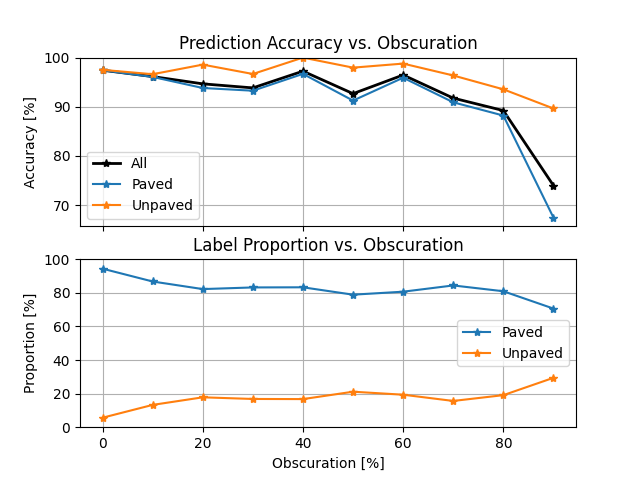

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
bins = np.linspace(0, 1, 10 + 1)

acc = []
counts = []
for obsc_min, obsc_max in zip(bins[:-1], bins[1:]):
    this_df = df[(obsc_min <= df['pred_Obscured']) & (df['pred_Obscured'] < obsc_max)]
    correct_df = this_df[this_df['surface_tag'] == this_df['pred_label']]

    acc_all = len(correct_df) / len(this_df)
    acc_paved = len(correct_df[correct_df['surface_tag'] == 'paved']) / len(this_df[this_df['surface_tag'] == 'paved'])
    acc_unpaved = len(correct_df[correct_df['surface_tag'] == 'unpaved']) / len(this_df[this_df['surface_tag'] == 'unpaved'])
    acc.append([e * 100 for e in (acc_all, acc_paved, acc_unpaved)])

    count_paved = len(this_df[this_df['surface_tag'] == 'paved']) / len(this_df)
    counts.append((count_paved * 100., (1 - count_paved) * 100.))

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(bins[:-1] * 100, [a for a, _, _ in acc], 'k-*', linewidth=2)
ax[0].plot(bins[:-1] * 100, [(b, c) for _, b, c in acc], '-*')
ax[0].set_title('Prediction Accuracy vs. Obscuration')
ax[0].set_ylim(None, 100)  # type: ignore
ax[0].set_ylabel(r'Accuracy [%]')
ax[0].grid()
ax[0].legend(('All', 'Paved', 'Unpaved'))

ax[1].plot(bins[:-1] * 100, counts, '-*')
ax[1].set_title('Label Proportion vs. Obscuration')
ax[1].set_ylim(0, 100)
ax[1].grid()
ax[1].legend(['Paved', 'Unpaved'])
ax[1].set_ylabel(f'Proportion [%]')
ax[1].set_xlabel(r'Obscuration [%]')


plt.show()


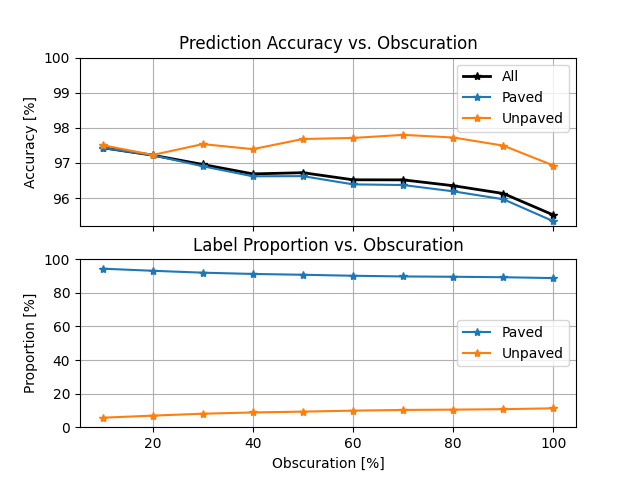

In [19]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
bins = np.linspace(0, 1, 10 + 1)

acc = []
counts = []
for obsc_max in bins[1:]:
    this_df = df[df['pred_Obscured'] < obsc_max]
    correct_df = this_df[this_df['surface_tag'] == this_df['pred_label']]

    acc_all = len(correct_df) / len(this_df)
    acc_paved = len(correct_df[correct_df['surface_tag'] == 'paved']) / len(this_df[this_df['surface_tag'] == 'paved'])
    acc_unpaved = len(correct_df[correct_df['surface_tag'] == 'unpaved']) / len(this_df[this_df['surface_tag'] == 'unpaved'])
    acc.append([e * 100 for e in (acc_all, acc_paved, acc_unpaved)])

    count_paved = len(this_df[this_df['surface_tag'] == 'paved']) / len(this_df)
    counts.append((count_paved * 100., (1 - count_paved) * 100.))

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(bins[1:] * 100, [a for a, _, _ in acc], 'k-*', linewidth=2)
ax[0].plot(bins[1:] * 100, [(b, c) for _, b, c in acc], '-*')
ax[0].set_title('Prediction Accuracy vs. Obscuration')
ax[0].set_ylim(None, 100)  # type: ignore
ax[0].set_ylabel(r'Accuracy [%]')
ax[0].grid()
ax[0].legend(('All', 'Paved', 'Unpaved'))

ax[1].plot(bins[1:] * 100, counts, '-*')
ax[1].set_title('Label Proportion vs. Obscuration')
ax[1].set_ylim(0, 100)
ax[1].grid()
ax[1].legend(['Paved', 'Unpaved'])
ax[1].set_ylabel(f'Proportion [%]')
ax[1].set_xlabel(r'Obscuration [%]')


plt.show()
